<a href="https://colab.research.google.com/github/Sarvi10/public-transport-analysis/blob/main/Passenger_journey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#  IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
from prophet import Prophet  # For forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
plt.style.use("seaborn-v0_8-darkgrid")   # to make the graph to look cleaner and readable
plt.rcParams["figure.figsize"] = (12,6)  # plots the clearer visualization of the plots

In [32]:
# COVERTING THE EXCEL TO CSV FILE AND LOADING THE DATASET

excel_file = "/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.xlsx"
csv_file = "/content/transport_dataset.csv"

excel_df = pd.read_excel(excel_file)
excel_df.to_csv(csv_file, index=False)

df = pd.read_csv(csv_file)

print("Excel file converted to CSV and loaded successfully.\n")
display(df.head())

Excel file converted to CSV and loaded successfully.



,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,2023-11-01 00:00:00,10536,8347,223,14072,0,48.0
4,2021-11-09 00:00:00,820,612,0,1283,0,11.0


In [33]:
# DETECTING DATE AND COLUMN

date_col = None
for col in df.columns:
    if "date" in col.lower():
        date_col = col
        break
if not date_col:
    raise ValueError("No date column found! Please check dataset.")

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

/tmp/ipython-input-582126684.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


In [34]:
# DETECTING NUMERIC VALUES AND CLEAN THEM

num_cols = df.select_dtypes(include="number").columns

df[num_cols] = df[num_cols].fillna(method="ffill").fillna(method="bfill")  # CLEANING THE MISSING VALUES

/tmp/ipython-input-1164841985.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_cols] = df[num_cols].fillna(method="ffill").fillna(method="bfill")  # CLEANING THE MISSING VALUES


In [35]:
# FEATURE ENGINEERING

for col in num_cols:
    df[col + "_DailyGrowth"] = df[col].pct_change().fillna(0) # ADD DAILY GROWTH FOR EACH NUMERIC FEATURE

df["Traffic_Index"] = df[num_cols].sum(axis=1) # COMBINED TRAFFIC INDEX

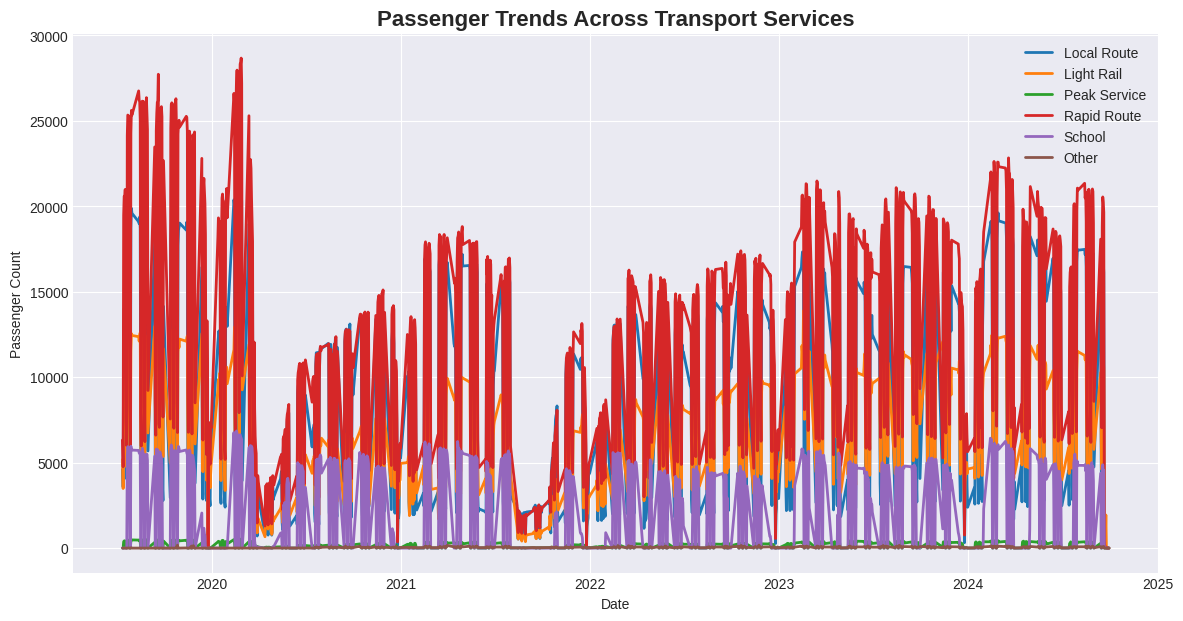

In [36]:
# MULTI-LINE TREND OF ALL NUMERIC FEATURES

plt.figure(figsize=(14,7))
for col in num_cols:
    plt.plot(df[date_col], df[col], linewidth=2, label=col)

plt.title("Passenger Trends Across Transport Services", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()

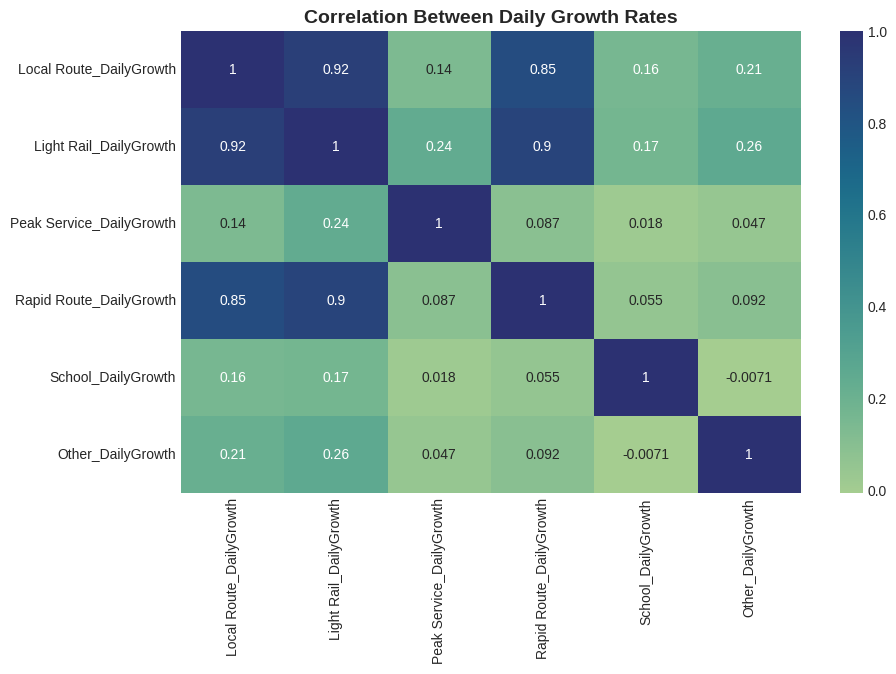

In [37]:
# HEATMAP OF THE DAILY GROWTH

plt.figure(figsize=(10,6))
growth_cols = [c for c in df.columns if "DailyGrowth" in c]
sns.heatmap(df[growth_cols].corr(), annot=True, cmap="crest")

plt.title("Correlation Between Daily Growth Rates", fontsize=14, weight="bold")
plt.show()

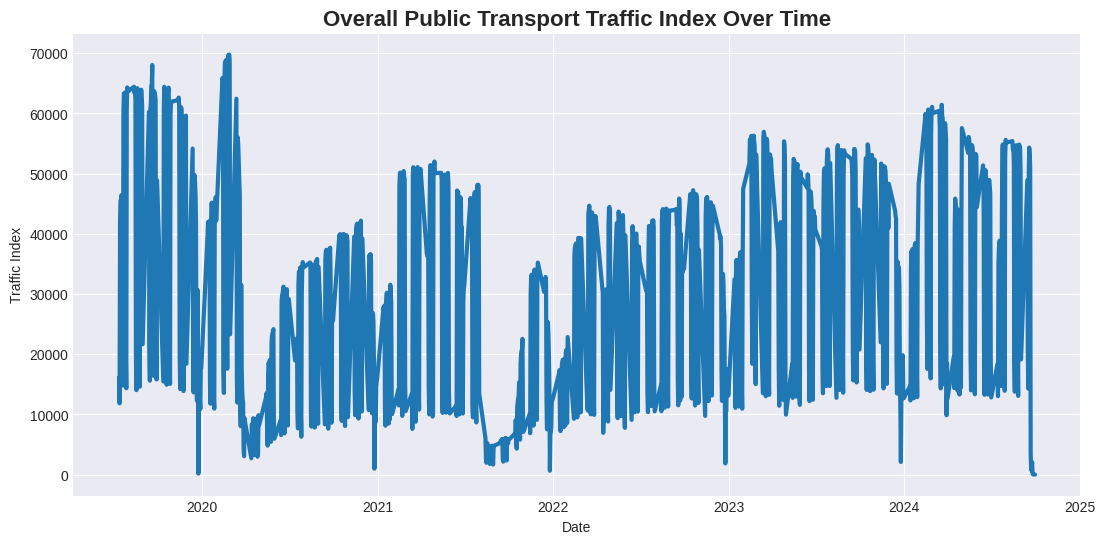

In [38]:
# TRAFFIC INDEX OVER TIME

plt.figure(figsize=(13,6))
plt.plot(df[date_col], df["Traffic_Index"], linewidth=3)

plt.title("Overall Public Transport Traffic Index Over Time", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Traffic Index")
plt.show()

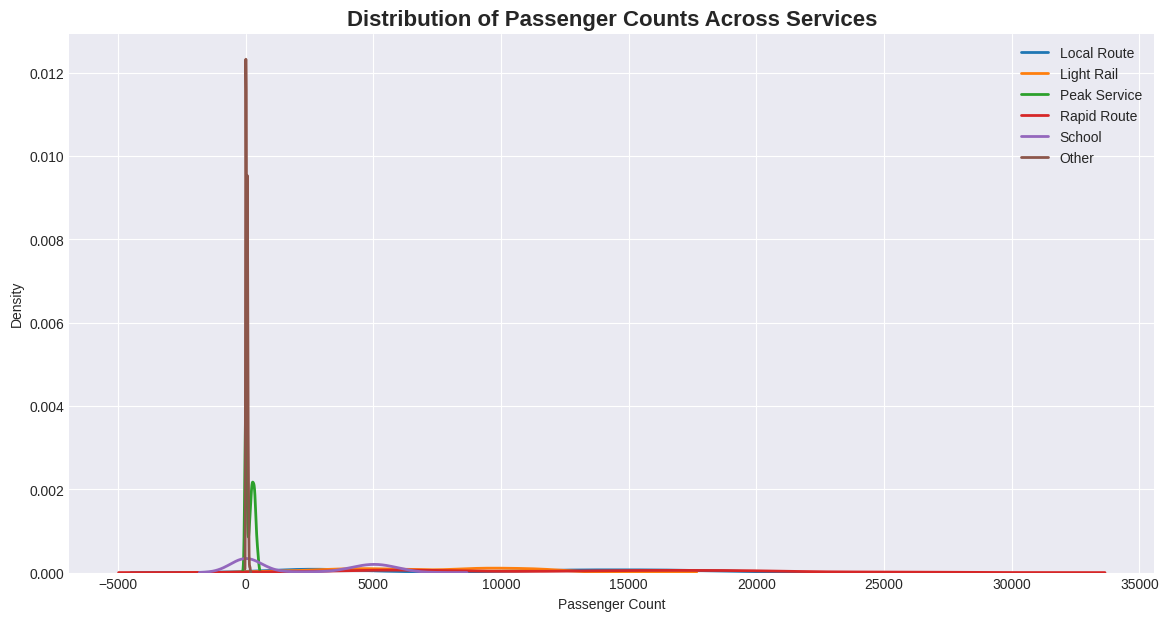

In [39]:
# DISTRIBUTION OF EACH SERVICE TYPE

plt.figure(figsize=(14,7))
for col in num_cols:
    sns.kdeplot(df[col], linewidth=2, label=col)

plt.title("Distribution of Passenger Counts Across Services", fontsize=16, weight="bold")
plt.xlabel("Passenger Count")
plt.legend()
plt.show()

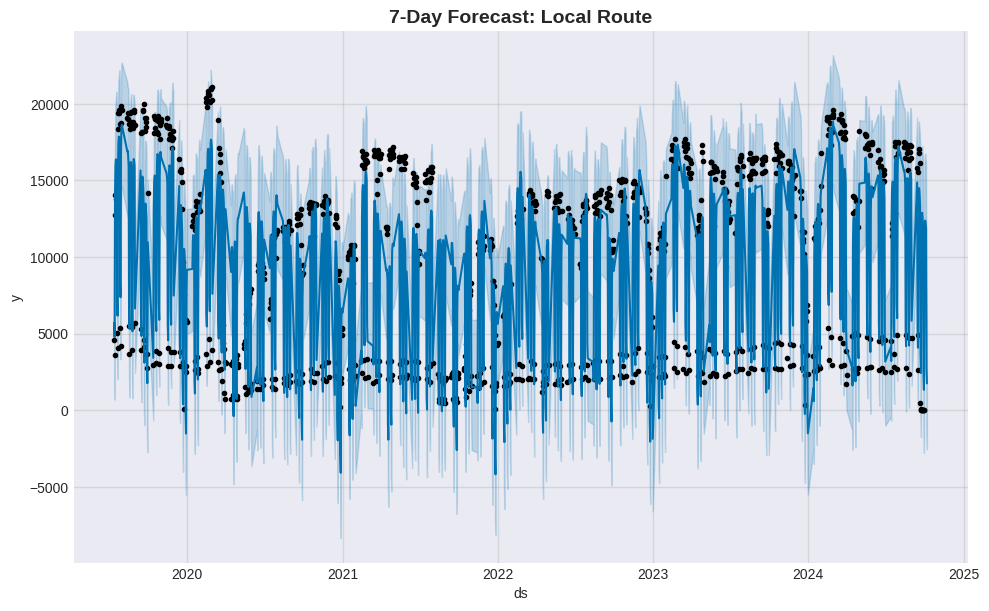

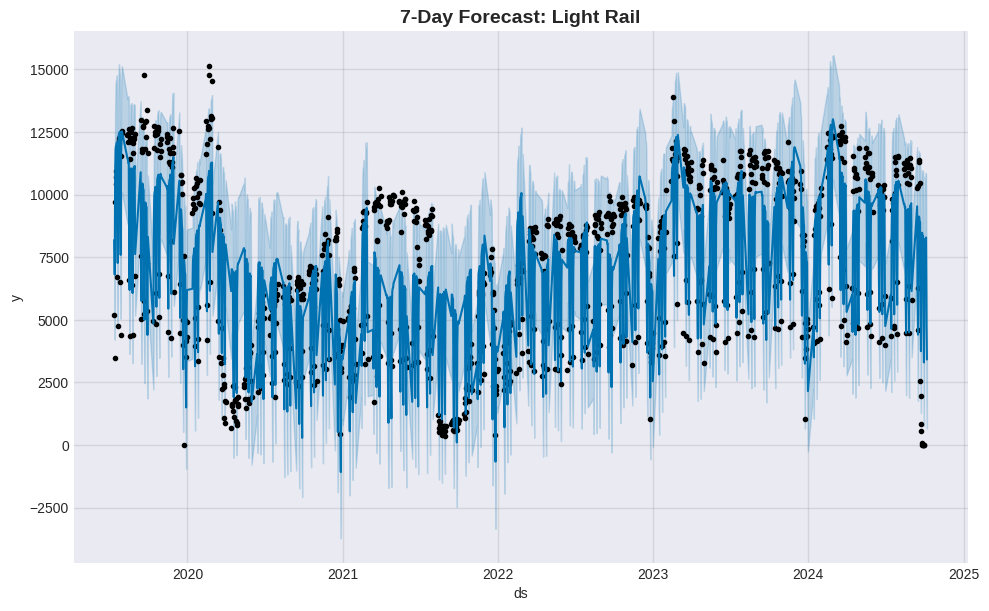

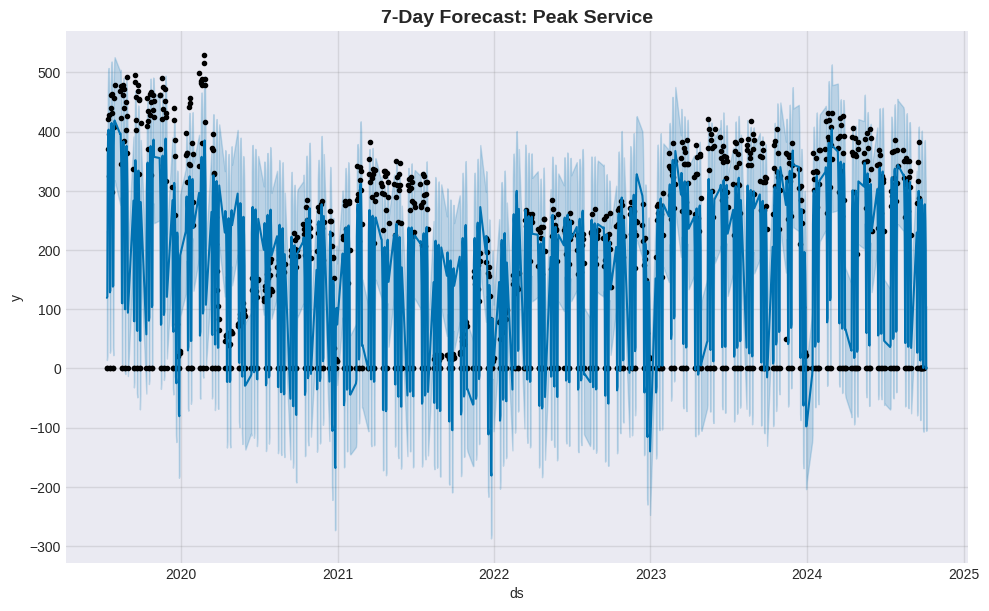

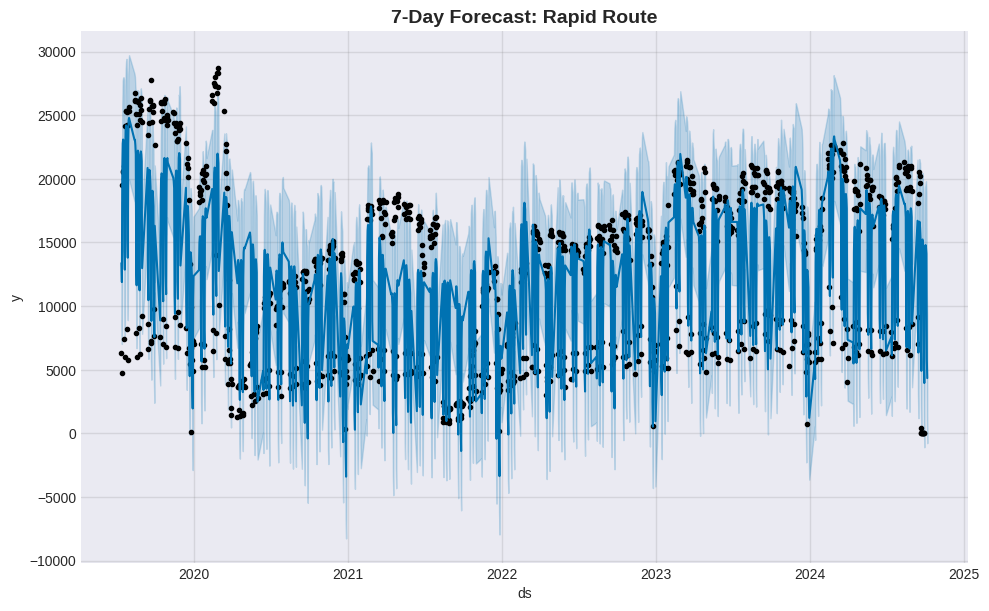

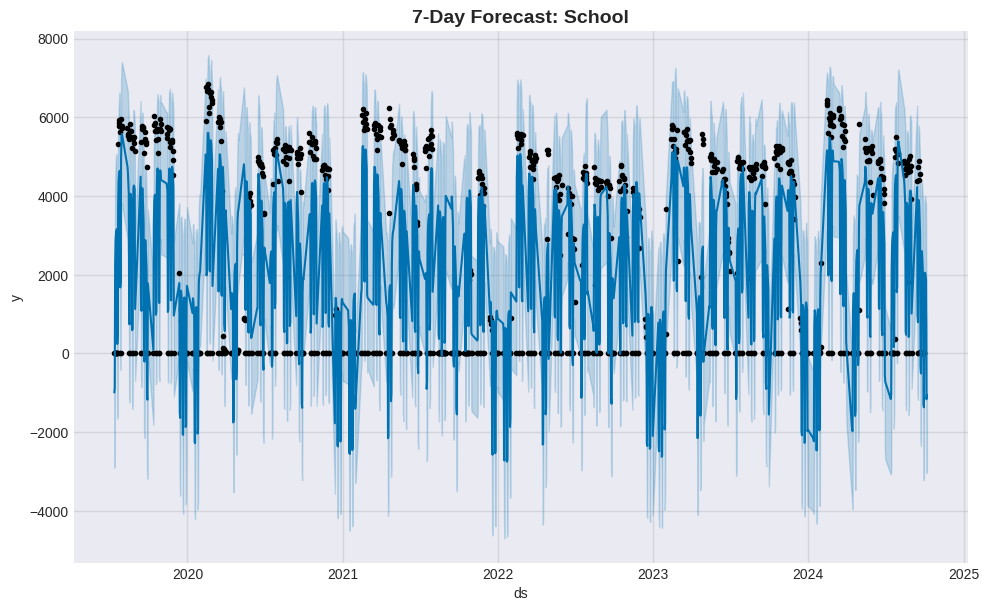

7-day forecasts saved to 'forecasts_next7.csv'.


,ds,Local Route,Light Rail,Peak Service,Rapid Route,School
0,2024-09-30,10567.442485,7238.327976,235.698165,12745.812230,1605.719624
1,2024-10-01,12145.442006,8165.224612,275.068505,14589.756555,2042.335966
2,2024-10-02,12376.121635,8234.121214,277.244372,14797.324989,2049.275594
3,2024-10-03,12201.711521,8173.491119,248.731654,14584.942970,1968.275175
4,2024-10-04,11875.682870,8287.001933,199.546004,14104.201091,1879.418736
5,2024-10-05,2667.364540,4784.276585,-1.048835,5768.051174,-1162.936414
6,2024-10-06,1748.161630,3414.693854,1.536303,4342.472102,-1052.523597


In [40]:
# FORECAST FOR NEXT 7 DAYS

os.makedirs("../images", exist_ok=True)
forecast_results = pd.DataFrame()

services_to_forecast = ["Local Route", "Light Rail", "Peak Service", "Rapid Route", "School"]

for service in services_to_forecast:
    if service not in df.columns:
        continue  # Skip if column not in dataset

    # Prepare data for Prophet
    prophet_df = df[[date_col, service]].rename(columns={date_col: 'ds', service: 'y'})

    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=7)  # next 7 days
    forecast = model.predict(future)

    # Save forecast values
    forecast_7days = forecast[['ds', 'yhat']].tail(7).rename(columns={'yhat': service})
    if forecast_results.empty:
        forecast_results = forecast_7days
    else:
        forecast_results = forecast_results.merge(forecast_7days, on='ds')

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f"7-Day Forecast: {service}", fontsize=14, weight="bold")
    plt.savefig(f"../images/forecast_{service.replace(' ','_')}.png")
    plt.show()

# Save all forecasts to CSV
forecast_results.to_csv("../forecasts_next7.csv", index=False)
print("7-day forecasts saved to 'forecasts_next7.csv'.")
display(forecast_results)